In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optim

from itertools import product

# Always make it pretty.
plt.style.use('ggplot')

import samplers as spl

# Statistical Models and Model Estimation

Our goal today is to begin **fitting statistical models to data** and **understand some of thier mathematical properties**.  At the end of the day we will be able to answer questions like:

  - While getting ready for work, after waking up at 6:00, you observe busses stopping at your bus stop at 6:12, 6:15, 6:20, 6:21, and 6:30, after which you leave to the bus stop at 6:33.  What is the probability you will have to wait longer than 5 minutes for the next bus?
  - You survey 100 randomly chosen students from a university, and find that their average height is 1.6 meters, with 25% of them taller than 1.8 meters.  If the university has 5000 students, approximately how many are taller than 2 meters?
  - Your friend's class notes refer to pages 11, 15, 55, 57, 102, 104, and 202 of a book.  What is a good estiamte for the number of pages in the book?

The process for solving problems like this goes:

1. Use domain knowledge and/or creativity to create a **statistical model** for your data, this is a *catalouge* of possible ways that the data may have been generated.
1. **Fit** the statistical model to the data.  This selects **exactly one** of the data generating processes from your catalouge.
1. Use the fit model to **compute** the thing you want.

The process above is the most basic form of **statistics**.

## Probability vs. Statistics

Probability and Statistics are closely related subjects, but there is a fundamental difference.

### Probability

In **probability** we *know* the parameters of a distribution (associated with some random variable), and we would like to study properties of data generated from that distribution.

Example properties of random varaibles are:

The **expectation** of a random varaible is defined by:

$$ E[X] = \int_{- \infty}^{\infty} t \
f_{X}(t) dt $$

and the **variance** is defined by

$$ V[X] = E \left[ (X - E[X])^2 \right] $$

If you *know* the parameters of the distribution, then you can *compute* the mean and variance.

### Statistics

In **statistics** we have data generated from a random variable, and we would like to *infer* properties of its distribution.

A few points are evident:

  - Independent and identically distributed data are important, as they allow us to pool information using data all generated from *indistinguishable* random variables.
  - We can never know *exactly* the distribution that generated the data, we can only hope to approximate it.
  - We *may* be able to quantify the uncertainty in our approximation (this is what much of classical statistics is about).

**Question**: Statistics, in its early days, was called **inverse probability**.  Can you see why?

## A Useful Visualization

Suppose we have some static, fixed data.  Here's an example dataset:

In [2]:
data = spl.secret_data()
print(data)

[-1.14658988  0.29380903  0.41840063  0.10666351  0.14992096 -1.2229341
  0.75898622 -0.6984492  -0.17591531  1.04638949 -0.04950167 -0.60703365
  0.39359816 -0.68573412  0.72693068  0.02449819  0.381768    0.47568179
  0.52821144 -0.08440477  0.50407509  0.26767895  0.22001586  0.80431172
  0.81448431 -0.61303303  0.51727072 -0.48731466 -0.45198099  0.85086404
  0.23252995  0.05994772 -0.79827686 -0.70068688  0.81243675  0.64037605
 -0.53464257  0.27242801  0.07135605 -0.81438619  0.23880051  0.12329983
 -0.98380523 -0.51077184  0.28961621 -0.38807926  1.05845798 -1.73088066
  0.67750893 -0.52493559]


We'll probably learn more if we actually draw some pictures of this data set.  For a one dimensional data set there are a few options, but a scatter plot is always a good default choice because it

  - Shows all the data
  - Is easy to interpret
  - Doesn't lose any information

In [3]:
def one_dim_scatterplot(data, ax, jitter=0.2, **options):
    if jitter:
        jitter = np.random.uniform(-jitter, jitter, size=data.shape)
    else:
        jitter = np.repeat(0.0, len(data))
    ax.scatter(data, jitter, **options)
    ax.yaxis.set_ticklabels([])
    ax.set_ylim([-1, 1])

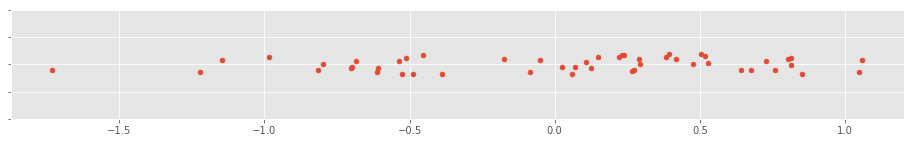

In [4]:
fig, ax = plt.subplots(1, figsize=(16, 2))
one_dim_scatterplot(data, ax, s=25)

#### The Empirical Distribution Function

Another possibility for one dimensional data visualization is to plot the **empirical distribution function**:

In [5]:
def emperical_distribution(x, data):
    weight = 1.0 / len(data)
    count = np.zeros(shape=len(x))
    for datum in data:
        count = count + np.array(x >= datum)
    return weight * count

Text(0.5,1,'The Empirical Distribution Function of a Dataset')

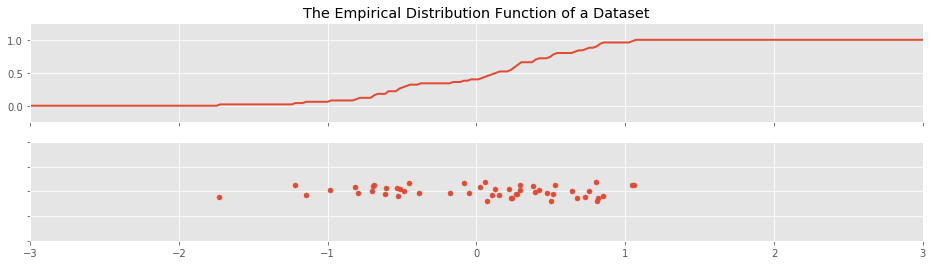

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(16, 4), sharex=True)

x = np.linspace(-3, 3, num=250)
ax[0].plot(x, emperical_distribution(x, data), linewidth=2)
ax[0].set_ylim(-0.25, 1.25)
ax[0].set_xlim(-3, 3)
one_dim_scatterplot(data, ax[1], s=25)
ax[0].set_title("The Empirical Distribution Function of a Dataset")

**Question:** How is the EDF drawn? When does it increase?  How much does it increase each time?  What is it attempting to approximate?

#### The Empirical Distribution

The emperical distribution function really is the CDF of a distribution (though it's a bit of a weird one when you first see it).

If you have a dataset ${x_1, x_2, \ldots, x_n}$, then you can make a distribution by putting a weight of $\frac{1}{n}$ on each data point.  That is, when you sample from this distribution, you just take one of the datapoints from the dataset, and each data point is equally likely to be chosen.

Text(0.5,1,'The Emperical Distribution of a Dataset')

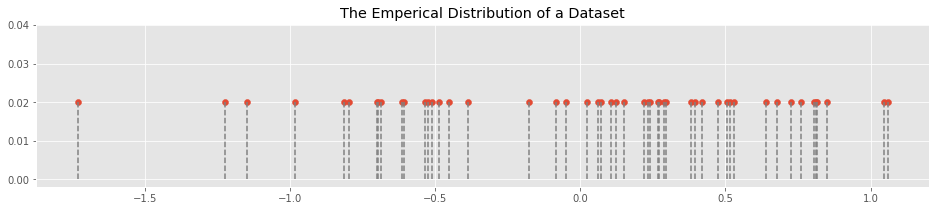

In [7]:
fig, ax = plt.subplots(figsize=(16, 3))

n_data = len(data)
y = np.repeat(1/n_data, n_data)

ax.scatter(data, y)
ax.vlines(x=data, ymin=0, ymax=(1/n_data), color='grey', linestyle='--')
ax.set_title("The Emperical Distribution of a Dataset")

**Question:** Say you draw a sample from this distribution (of any size).  How would you describe this process?

Samples taken from the empirical distribution of a dataset are called **Bootstrap Samples**, and they are very important in modern, computer aided statistics.  We will discuss bootstrap samples this afternoon.

## Introductory Definitions

So, we arrive at a very fundamental question:  **Just want is a statistical model anyway?**

We would like to do some statistics, that is, go **from** the data, **to** an understanding of a process that may have generated the data.

A **statistical model** is a collection of random variables, each of which is hypothesized to possibly have generated the data.  Different random variables in the collection are usually distinguished by **parameters**.

**Fitting a statistical model to data** is any process that combines a model with data, and uses the data to select one and only one random variable from the model.  This often takes the form of **determining the parameters for one and only one of the random variables in the model**.  These estimated values of the parameters are called **parameter estimates**.

**Warning:** This terminology is one of the *most abused* in all of statistics.  Formally, the *model* is a **collection** of possible data generating process, but *everyone* also refers to the *single* object you get after fitting the model to data as "the model".  **Seriously everyone does this**, but it's technically incorrect.

**Questions**:
    
What are appropriate statistical models for the following situations:
    
  - You ride an airplane and observe if you catch the flu.
  - You count the number of busses stopping at a bus stop in a given interval of time.  
  - You randomly choose students from a university, and measure their heights.

### Example: Normal Distribution with Unknown Mean, and Known Variance.

Let's fit a model to our data from before.  Suppose we suspect, because we are smart and can infer such things, that our data is generated from a normal distribution with **unknown mean**, but we know the variance is $1$ (this is not something you can generally know, we're assuming it here just for simplicity).

Then, our **statistical model** is the following collection of random variables:

$$ M = \{ Normal(\mu, 1) \mid \mu \in \mathbb{R} \} $$

The **parameter** at play is the unknown mean of the normal distribution (since we are assuming we know the variance, that's not a parameter).


Text(0.5,1,'Distributions in the Unknown Mean Known Varaince Model')

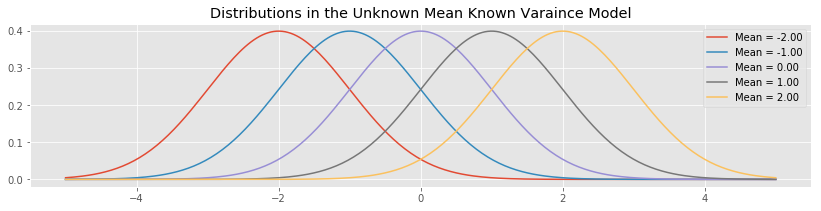

In [8]:
x = np.linspace(-5, 5, num=250)
fig, ax = plt.subplots(figsize=(14, 3))

means = np.linspace(-2, 2, num=5)
for mean in means:
    normal = spl.Normal(mean, 1)
    ax.plot(x, normal.pdf(x), label="Mean = {:2.2f}".format(mean))
    
ax.legend()
ax.set_title("Distributions in the Unknown Mean Known Varaince Model")

By **fitting the model to data** we mean any process that selects exactly *one* of these distributions.  This reduces, in this case, to selecting the mean parameter $\mu$ of the unknown normal distribution.

## The Eyeball Method

Let's fit our model with the **eyeball method**, we will sample new data sets of the same size as our data from normal distributions of varying mean, and then pick the distribution that best resembles our data.

In [9]:
def text_in_blank_plot(text, ax):
    _ = ax.text(0.5, 0.5, text, 
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=22)
    ax.axis('off')

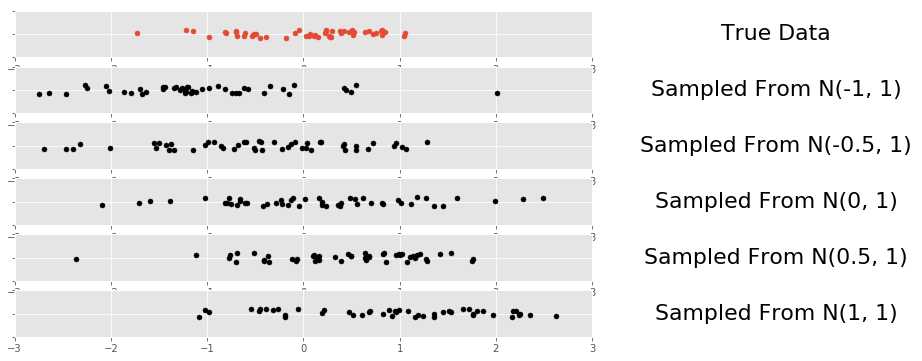

In [10]:
means = [-1, -0.5, 0, 0.5, 1]

fig = plt.figure(figsize=(16, 6)) 
ax = plt.subplot2grid((6, 3), (0, 0), colspan=2)
ax.set_xlim(-3, 3)
one_dim_scatterplot(data, ax, s=25)
ax = plt.subplot2grid((6, 3), (0, 2), colspan=1)
text_in_blank_plot("True Data", ax)

for i, mu in enumerate(means):
    normal = spl.Normal(mu, 1)
    sample = normal.sample(50)
    ax = plt.subplot2grid((6, 3), (i + 1, 0), colspan=2)
    ax.set_xlim(-3, 3)
    one_dim_scatterplot(sample, ax, s=25, c="black")   
    ax = plt.subplot2grid((6, 3), (i + 1, 2), colspan=1)
    text_in_blank_plot("Sampled From N({}, 1)".format(mu), ax)

Another way to eyeball is to compare the **emperical CDF** to the actual CDFs of the canidate distributions.

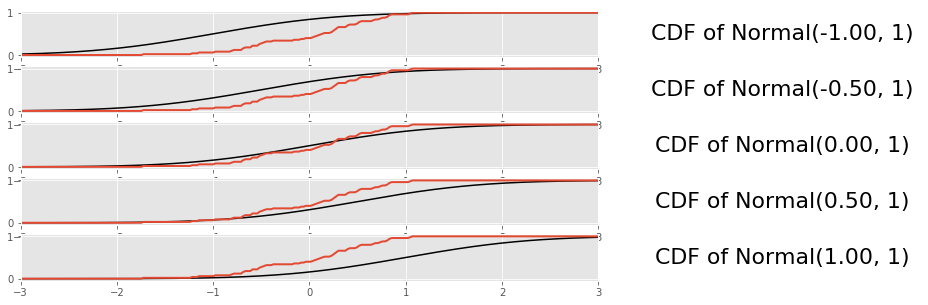

In [11]:
means = [-1, -0.5, 0, 0.5, 1]

fig = plt.figure(figsize=(16, 6)) 

x = np.linspace(-3, 3, num=250)

for i, mu in enumerate(means):
    normal = spl.Normal(mu, 1)
    ax = plt.subplot2grid((6, 3), (i + 1, 0), colspan=2)
    ax.set_xlim(-3, 3)
    ax.plot(x, normal.cdf(x), color="black")
    ax.plot(x, emperical_distribution(x, data), linewidth=2)
    ax = plt.subplot2grid((6, 3), (i + 1, 2), colspan=1)
    text_in_blank_plot("CDF of Normal({:2.2f}, 1)".format(mu), ax)

It's kind of hard to eyeball here, but it looks like $N(0, 1)$ is our best choice.

This eyeball method clearly has some downfalls

  - To make it feasible, we needed to discrete the values of $\mu$ we were considering to a small set.  It would be better to consider *all* the possible $\mu$'s at once.
  - If there were more parameters, mean and variance for example, the number of candidate distributions we needed to consider would grow exponentially.
  - It's hard to eyeball which candidate looks best by comparing simulated to real data.  Better would be a disciplined measurement of "how different are the datasets?".

**Question:** If we were searching both the mean and varaince parameters above, how many pictures would we need to compare?  How does this change as the number of parameters increases?

The **method of moments** and the **method of maximum likelihood** have been developed to address the above concerns.

## The Maximum Likelihood Method

The **maximum likelihood method** is the gold standard method for fitting statistical models to data.  Almost all models used in modern times use some version of the maximum likelihood method.

Our goal is to make the following philosophy of model fitting precise

> The fit model should be the random variable *most likely* to generate the data.

We already know how to generate data, this is just *sampling*, so we need to make the phrase *most likely* precise.

**Question:** Consider the following density function of a normal distribution.

What is the data value *most likely to be generated* when sampling from this distribution?

Text(0.5,1,'Normal(2, 1) Density Function')

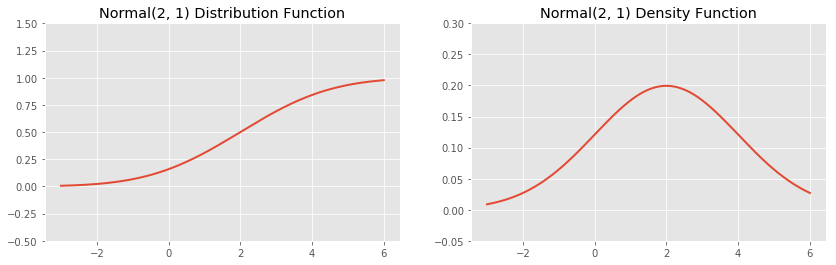

In [12]:
normal = spl.Normal(2, 2)

x = np.linspace(-3, 6, num=250)
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0].plot(x, normal.cdf(x), linewidth=2)
ax[0].set_ylim(-0.5, 1.5)
ax[0].set_title("Normal(2, 1) Distribution Function")

ax[1].plot(x, normal.pdf(x), linewidth=2)
ax[1].set_ylim(-0.05, 0.3)
ax[1].set_title("Normal(2, 1) Density Function")

**Question:** Consider a single data value, represented in the plots below as a large black dot.  Which is the *normal distribution most likely to have generated this data point*?  Note, this is the reverse question from the previous one.  Pay attention to possible objections to your answer.

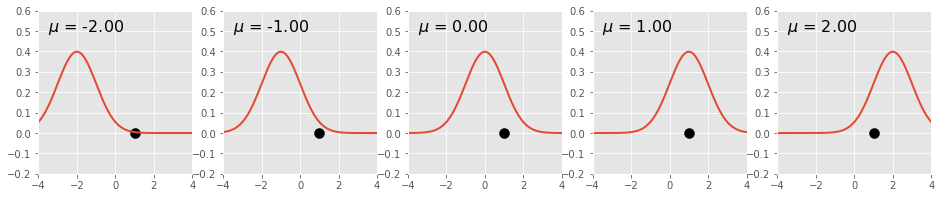

In [13]:
mus = [-2, -1, 0, 1, 2]
normal_dists_varying_mean = [spl.Normal(mu, 1) for mu in mus] 

x = np.linspace(-4, 4, num=250)
fig, axs = plt.subplots(1, 5, figsize=(16, 3))

for i, ax in enumerate(axs.flatten()):
    ax.plot(x, normal_dists_varying_mean[i].pdf(x), linewidth=2)
    ax.scatter([1], [0], s=100, c="black")
    ax.set_ylim(-0.2, 0.6)
    ax.set_xlim(-4, 4)
    ax.text(-3.5, 0.5, r"$\mu$ = {:2.2f}".format(mus[i]),
            fontsize=16)

The distribution most likely to generate the point is, intuitively, the one where the *mode* of the distribution *coincides with* the data value.

**Counterpoint:** Isn't the probability that **any** of these distributions generates the data point **exactly** equal to zero?

Said differently, to find the distribution that is most likely to have generated a data point $x$, we find the parameter $\theta$ that maximizes the density function evaluated at $x$

$$ \text{maximize by finding} \ \theta \ \{ f(x; \theta) \} $$

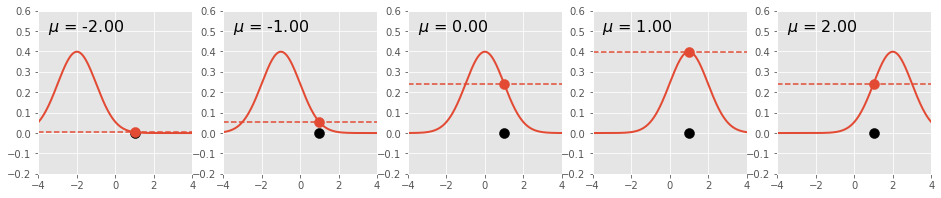

In [14]:
normal_dists_varying_mean = [
    spl.Normal(mu, 1) for mu in [-2, -1, 0, 1, 2]
]

x = np.linspace(-4, 4, num=250)
fig, axs = plt.subplots(1, 5, figsize=(16, 3))

for i, ax in enumerate(axs.flatten()):
    ax.plot(x, normal_dists_varying_mean[i].pdf(x), linewidth=2)
    ax.scatter([1], [0], s=100, c="black")
    ax.scatter([1], [normal_dists_varying_mean[i].pdf(1)], s=100)
    ax.axhline(y=normal_dists_varying_mean[i].pdf(1), linestyle="--") 
    ax.set_ylim(-0.2, 0.6)
    ax.set_xlim(-4, 4)
    ax.text(-3.5, 0.5, r"$\mu$ = {:2.2f}".format(mus[i]),
        fontsize=16)

When our data $x$ is fixed, and we are thinking of changing $\theta$, we call this the **likelihood function**.

$$ L(\theta) = f(x; \theta) $$

Text(0.5,0,'$\\mu$')

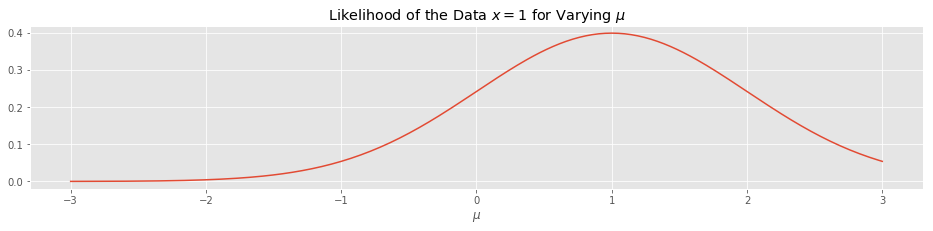

In [15]:
fig, ax = plt.subplots(figsize=(16, 3))

x = 1  # This is the fixed data
t = np.linspace(-3, 3, num=250)

def likelihood(mu):
    normal = spl.Normal(mu, 1)
    return normal.pdf(x)

ax.plot(t, likelihood(t))
ax.set_title("Likelihood of the Data $x = 1$ for Varying $\mu$")
ax.set_xlabel("$\mu$")

### Definition

Suppose $M$ is a statistical model, with a parameter $\theta$.  Then each of the random variables in the model has a density function, and the parameter $\theta$ appears in the density function

$$ f(t; \theta) $$

Denote by $x_i$ a set of data.

The **likelihood function of the model given the data** is a function of the **parameter**, it informally measures the likelihood of observing the data you have as you vary the parameters in the model

$$ L(\theta) = \prod_i f(x_i; \theta) $$

In practice, the log-likelihood is more useful

$$ LL(\theta) = \sum_i \log( f(x_i, \theta) ) $$

To **fit a model by the likelihood method we find the parameters $\theta$ that maximize the likelihood function**.

### Example: Normal Distribution, Unknown Mean

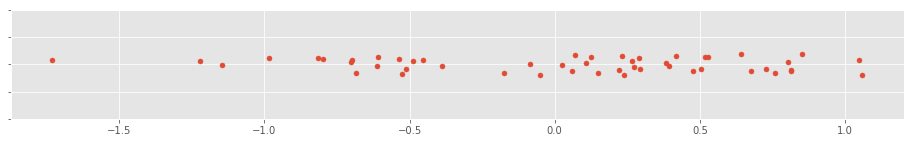

In [16]:
fig, ax = plt.subplots(1, figsize=(16, 2))
one_dim_scatterplot(data, ax, s=25)

And attempt to fit a normal distribution to this data using the likelihood method.

#### Step 1: Write down the model.

Our model contains all normal random variables.  We will assume the varaince is knows (in particular, we'll assume it is one), but the mean is unkown.

$$ M = \{ N(\mu, 1) \mid \mu \in \mathbb{R} \} $$

#### Step 2: Write down the density functions of all the random variables in the model.

The density function of a normal distribution with unknown mean and variance is:

$$ f(t; \mu) = \frac{1}{\sqrt{2 \pi}} e^{ - \frac{(t - \mu)^2}{2}} $$

This pdf has arguments for both the **data** and the **parameter**:

$$ f(\underbrace{t}_{\text{data}}; \underbrace{\mu}_{\text{parameter}}) $$

I can access this function in python by using `spl.Normal(mu, 1).cdf(t)`.

#### Step 3: Write code to compute the log likelihood function of the model given the data.

Remember that the data is *fixed* and we want to vary the *parameters*, so the way we write our function should respect that.

In [17]:
def log_likelihood_normal_one_parameter(mu):
    normal = spl.Normal(mu, 1.0)
    likelihoods = [normal.pdf(datum) for datum in data]
    return np.sum(np.log(likelihoods))

def minus_log_likelihood_normal_one_parameter(mu):
    return -log_likelihood_normal_one_parameter(mu)

Text(0.5,1,"Log-Likelihood of One Parameter Normal Model for Various $\\mu$'s")

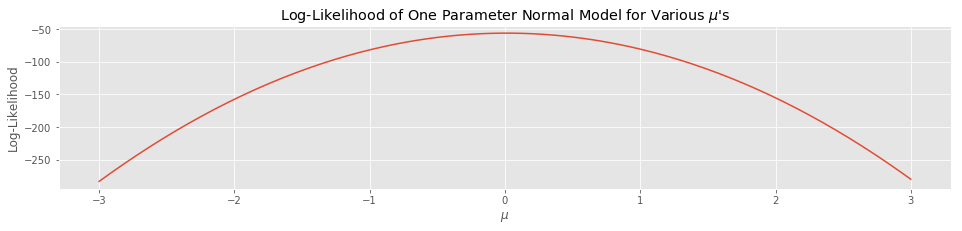

In [18]:
mus = np.linspace(-3, 3, num=250)

fig, ax = plt.subplots(figsize=(16, 3))
ax.plot(mus, [log_likelihood_normal_one_parameter(mu) for mu in mus])

ax.set_xlabel(r"$\mu$")
ax.set_ylabel("Log-Likelihood")
ax.set_title(r"Log-Likelihood of One Parameter Normal Model for Various $\mu$'s")

#### Step 4: Find the parameters that maximize the log-likelihood.

Eyeballing our simple grid search above, it seems like $\mu = 0$ is the best of what we tried.

In practice, we use an algorithm like **gradient descent** to find a good approximation to the maximal parameters, this process is called **optimization**.

In python, we can use built in optimizer to find the maximal parameters.

In [19]:
# The optimizer needs a function that consumes a single numpy array
def wrapper_for_scipy_one_parameter(x):
    return minus_log_likelihood_normal_one_parameter(x[0])

fit_parms = optim.minimize(wrapper_for_scipy_one_parameter, (0,), method='Nelder-Mead')
mu_hat = fit_parms.x

print("Log-Lik Optimal Parameters: mu = {0:2.3f}".format(mu_hat[0]))

Log-Lik Optimal Parameters: mu = 0.011


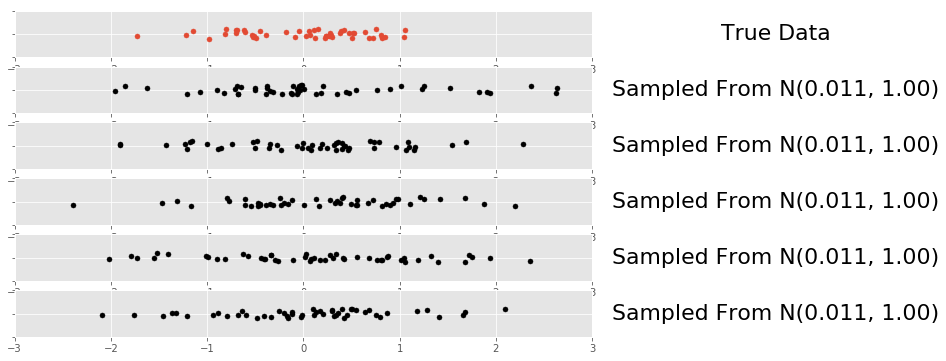

In [20]:
fig = plt.figure(figsize=(16, 6)) 
ax = plt.subplot2grid((6, 3), (0, 0), colspan=2)
ax.set_xlim(-3, 3)
one_dim_scatterplot(data, ax, s=25)
ax = plt.subplot2grid((6, 3), (0, 2), colspan=1)
text_in_blank_plot("True Data", ax)

for i in range(5):
    normal = spl.Normal(mu_hat, 1)
    sample = normal.sample(50)
    ax = plt.subplot2grid((6, 3), (i + 1, 0), colspan=2)
    ax.set_xlim(-3, 3)
    one_dim_scatterplot(sample, ax, s=25, c="black")
    ax = plt.subplot2grid((6, 3), (i + 1, 2), colspan=1)
    text_in_blank_plot("Sampled From N({0:0.3f}, 1.00)".format(
                       mu_hat[0]), ax)

In [21]:
def superimpose_pdf_of_fit_model(data, model, ax, x_lower=-3, x_upper=3):
    x = np.linspace(x_lower, x_upper, num=250)
    _ = ax.hist(data, bins=25, normed=True, color="black", alpha=0.4)
    ax.plot(x, model.pdf(x), linewidth=3)

/Users/matthewdrury/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


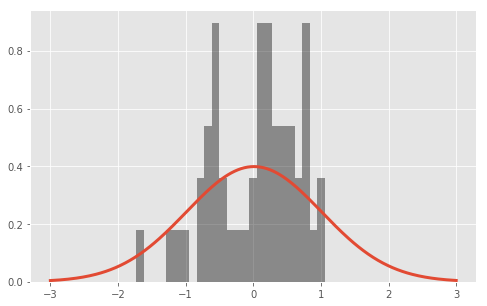

In [22]:
fit_one_param_model = spl.Normal(mu_hat, 1.0)

fig, ax = plt.subplots(1, figsize=(8, 5))
superimpose_pdf_of_fit_model(data, fit_one_param_model, ax)

In [23]:
def superimpose_cdf_of_fit_model(data, model, ax, x_lower=-3, x_upper=3):
    x = np.linspace(x_lower, x_upper, num=250)
    ax.plot(x, emperical_distribution(x, data), linewidth=2)
    ax.plot(x, model.cdf(x), linewidth=2)

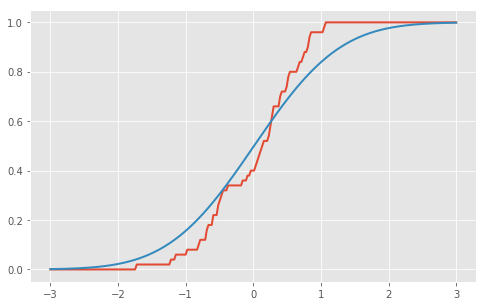

In [24]:
fig, ax = plt.subplots(1, figsize=(8, 5))
superimpose_cdf_of_fit_model(data, fit_one_param_model, ax)

### Example: Normal Distribution, Unknown Mean and Variance

Let's reuse the normal data from before

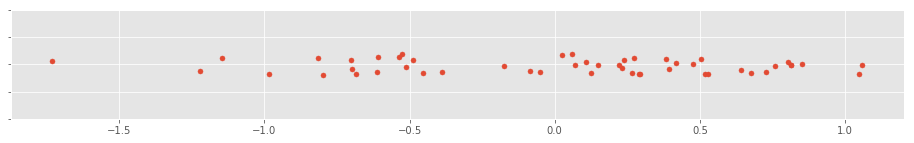

In [25]:
fig, ax = plt.subplots(1, figsize=(16, 2))
one_dim_scatterplot(data, ax, s=25)

And attempt to fit a normal distribution to this data using the likelihood method.

#### Step 1: Write down the model.

Our model contains all normal random variables with varying mean and variance.

$$ M = \{ N(\mu, \sigma^2) \mid \mu \in \mathbb{R}, \sigma^2 \in \mathbb{R}^+ \} $$

#### Step 2: Write down the density functions of all the random variables in the model.

The density function of a normal distribution with unknown mean and variance is:

$$ f(t; \mu, \sigma^2) = \frac{1}{\sqrt{2 \sigma^2 \pi}} e^{ - \frac{(t - \mu)^2}{2 \sigma^2}} $$

This pdf has arguments for both the **data** and the **parameters**:

$$ f(\underbrace{t}_{\text{data}}; \underbrace{\mu, \sigma^2}_{\text{parameters}}) $$

I can access this function in python by using `spl.Normal(mu, sigma).cdf(t)`.

#### Step 3: Write code to compute the log likelihood function of the model given the data.

Remember that the data is *fixed* and we want to vary the *parameters*, so the way we write our function should respect that.

In [26]:
def log_likelihood_normal_two_parameters(mu, sigma_sq):
    normal = spl.Normal(mu, np.sqrt(sigma_sq))
    likelihoods = [normal.pdf(datum) for datum in data]
    return np.sum(np.log(likelihoods))

def minus_log_likelihood_normal_two_parameters(mu, sigma):
    return -log_likelihood_normal_two_parameters(mu, sigma)

As a sanity check, we can evaluate the log-likelihood function at varaious values of the parameters.

In [27]:
for mu, sigma_sq in product([-1, 0, 1], [0.5, 1, 2]):
    print("Log-Lik of Two Parameter Normal Model With mu={0}, sigma_sq={1}: {2:3.2f}".format(
        mu, sigma_sq, log_likelihood_normal_two_parameters(mu, sigma_sq)
    ))

Log-Lik of Two Parameter Normal Model With mu=-1, sigma_sq=0.5: -100.36
Log-Lik of Two Parameter Normal Model With mu=-1, sigma_sq=1: -81.82
Log-Lik of Two Parameter Normal Model With mu=-1, sigma_sq=2: -81.21
Log-Lik of Two Parameter Normal Model With mu=0, sigma_sq=0.5: -49.26
Log-Lik of Two Parameter Normal Model With mu=0, sigma_sq=1: -56.27
Log-Lik of Two Parameter Normal Model With mu=0, sigma_sq=2: -68.44
Log-Lik of Two Parameter Normal Model With mu=1, sigma_sq=0.5: -98.16
Log-Lik of Two Parameter Normal Model With mu=1, sigma_sq=1: -80.72
Log-Lik of Two Parameter Normal Model With mu=1, sigma_sq=2: -80.66


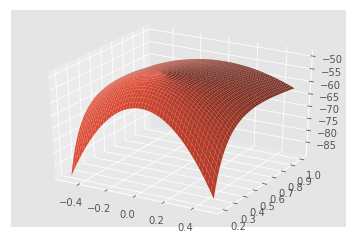

In [42]:
from mpl_toolkits.mplot3d import Axes3D
from pylab import meshgrid

mus = np.linspace(-0.5, 0.5, num=50)
sigmas = np.linspace(0.2, 1.0, num=50)

X, Y = meshgrid(mus, sigmas)
Z = np.array([
        [log_likelihood_normal_two_parameters(mu, sigma_sq)] 
         for mu, sigma_sq in zip(X.flatten(), Y.flatten())]).reshape(X.shape)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z)
plt.show()

It looks like the the log-likelihood is maximized fo `mu=0, sigma_sq=0.5`, which seems reasonable given the plot of our data.

#### Step 4: Find the parameters that maximize the log-likelihood.

Eyeballing our simple grid search above, it seems like $\mu = 0, \sigma^2 = 0.5$ is the best of what we tried.

In practice, we use an algorithm like *gradient descent* to find a good approximation to the maximal parameters, this process is called **optimization**.

In python, we can use built in optimizer to find the maximal parameters.

In [29]:
# The optimizer needs a function that consumes a single numpy array
def wrapper_for_scipy(x):
    return minus_log_likelihood_normal_two_parameters(x[0], x[1])

fit_parms = optim.minimize(wrapper_for_scipy, (0, 1), method='Nelder-Mead')
mu_hat, sigma_sq_hat = fit_parms.x

print("Log-Lik Optimal Parameters: mu = {0:2.3f}, sigma_sq = {1:2.3f}".format(mu_hat, sigma_sq_hat))

Log-Lik Optimal Parameters: mu = 0.011, sigma_sq = 0.413


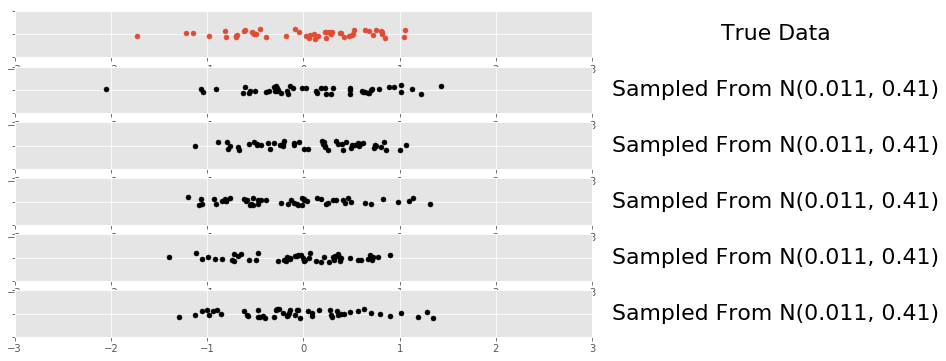

In [30]:
fig = plt.figure(figsize=(16, 6)) 
ax = plt.subplot2grid((6, 3), (0, 0), colspan=2)
ax.set_xlim(-3, 3)
one_dim_scatterplot(data, ax, s=25)
ax = plt.subplot2grid((6, 3), (0, 2), colspan=1)
text_in_blank_plot("True Data", ax)

for i in range(5):
    normal = spl.Normal(mu_hat, np.sqrt(sigma_sq_hat))
    sample = normal.sample(50)
    ax = plt.subplot2grid((6, 3), (i + 1, 0), colspan=2)
    ax.set_xlim(-3, 3)
    one_dim_scatterplot(sample, ax, s=25, c="black")
    ax = plt.subplot2grid((6, 3), (i + 1, 2), colspan=1)
    text_in_blank_plot("Sampled From N({0:0.3f}, {1:0.2f})".format(
                       mu_hat, sigma_sq_hat), ax)

/Users/matthewdrury/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


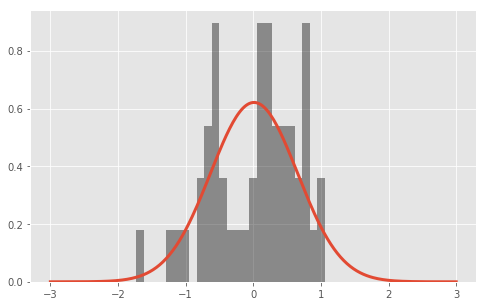

In [31]:
fit_two_param_model = spl.Normal(mu_hat, np.sqrt(sigma_sq_hat))

fig, ax = plt.subplots(1, figsize=(8, 5))
superimpose_pdf_of_fit_model(data, fit_two_param_model, ax)

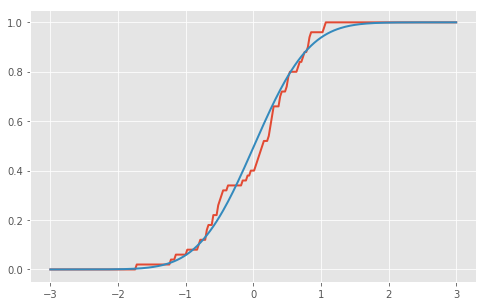

In [32]:
fig, ax = plt.subplots(1, figsize=(8, 5))
superimpose_cdf_of_fit_model(data, fit_two_param_model, ax)

## Bonus Example: Uniform Distribution: Both Bounds Unknown

Consider the following data, generated from an unknown uniform distribution.

In [33]:
unif = spl.Uniform(-1.1, 0.9)

unif_data = unif.sample(100)

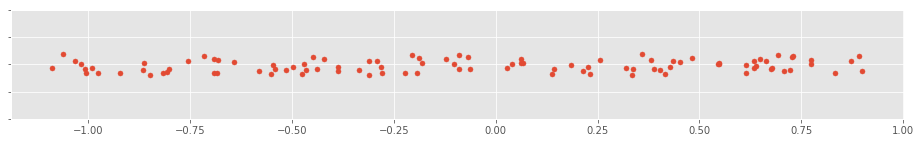

In [34]:
fig, ax = plt.subplots(1, figsize=(16, 2))
one_dim_scatterplot(unif_data, ax, s=25)

Our model is

$$ M = \{ \text{Unif}(a, b) \mid a < b \} $$

which we already derived the method of moments estimates for.  We'll encapsulate this in a function below.

In [35]:
def uniform_method_of_moments(data):
    mu_hat = np.mean(data)
    sigma_sq_hat = np.var(data)
    return mu_hat - np.sqrt(3 * sigma_sq_hat), mu_hat + np.sqrt(3 * sigma_sq_hat)

In [36]:
a, b = uniform_method_of_moments(unif_data)

print("Method of Moments estimates: a = {0:2.2f}, b = {1:2.2f}".format(a, b))

Method of Moments estimates: a = -1.08, b = 0.95


The maximum likelihood estimates of the parameters are

$$ \hat a = \min x_i, \ \hat b = \max x_i $$

**Bonus:** It's a worthwhile exercise to convince yourself this is true.  If you can do so, you really do understand maximum likelihood!

In [37]:
def uniform_maximum_likelihood(data):
    return data.min(), data.max()

In [38]:
a, b = uniform_maximum_likelihood(unif_data)

print("Maximum likelihood estimates: a = {0:2.2f}, b = {1:2.2f}".format(a, b))

Maximum likelihood estimates: a = -1.09, b = 0.90


This time the parameters estimated by the two methods are *different*.

We can check the fit of our model in the usual ways.

/Users/matthewdrury/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


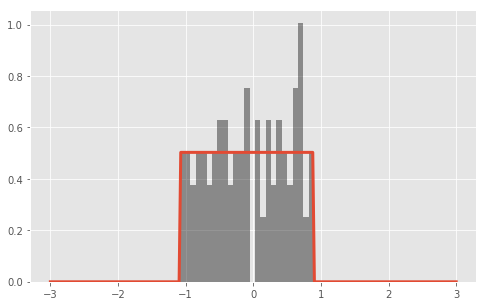

In [39]:
fit_unif_model = spl.Uniform(a, b)

fig, ax = plt.subplots(1, figsize=(8, 5))
superimpose_pdf_of_fit_model(unif_data, fit_unif_model, ax)

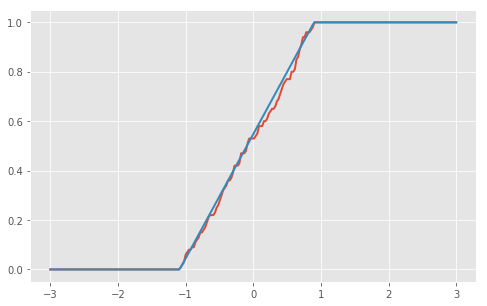

In [40]:
fit_unif_model = spl.Uniform(a, b)

fig, ax = plt.subplots(1, figsize=(8, 5))
superimpose_cdf_of_fit_model(unif_data, fit_unif_model, ax)